In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tqdm.auto import tqdm
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train.describe()

,id,Decision,Temperature,Children,Bar,Coffeehouse,Carryaway,Restaurantlessthan20,Restaurant20to50,Direction_same,Distance
count,10184.000000,10184.000000,10184.000000,10184.000000,10091.000000,10002.000000,10059.000000,10079.000000,10033.000000,10184.000000,10184.000000
mean,5092.500000,0.569914,63.361155,0.414277,1.038846,1.574285,2.416741,2.283064,1.269909,0.211115,1.684309
std,2940.011905,0.495112,19.137079,0.492621,1.095480,1.238135,0.929992,0.919968,0.882393,0.408120,0.675322
min,1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2546.750000,0.000000,55.000000,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
50%,5092.500000,1.000000,80.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,2.000000
75%,7638.250000,1.000000,80.000000,1.000000,2.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000
max,10184.000000,1.000000,80.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,3.000000


In [5]:
def find_unique(frame):
    unique_values = []
    for column_name in frame.columns:
        column = frame[column_name]
        unique_values.append((column_name, column.unique().shape[0], column.dtype))
    return pd.DataFrame(unique_values, columns=['column', 'count', 'dtype'])

find_unique(train)

,column,count,dtype
0,id,10184,int64
1,Decision,2,int64
2,Driving_to,3,object
3,Passanger,4,object
4,Weather,3,object
5,Temperature,3,int64
6,Time,5,object
7,Coupon,5,object
8,Coupon_validity,2,object
9,Gender,2,object


https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [6]:
x_train, y_train, ids = (
    train[train.columns[~np.isin(train.columns, ('Decision', 'id'))]],
    train['Decision'], train['id']
)


In [7]:
x_train_dummies, filled = pd.get_dummies(x_train), {}
x_train_not_na = x_train_dummies.dropna()

for col in tqdm(x_train_dummies.columns):
    x_train_minus_col = x_train_not_na[
        x_train_not_na.columns[x_train_not_na.columns != col]]
    bnb = BernoulliNB()
    bnb.fit(x_train_minus_col, 
            x_train_not_na.loc[x_train_minus_col.index, col])
    pred = bnb.predict(x_train_dummies[x_train_minus_col.columns]
                       .fillna(method='ffill'))
    filled[col] = pred
    
x_train_imputed = x_train_dummies.fillna(pd.DataFrame(filled))

scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_imputed),
                              index=x_train_imputed.index,
                              columns=x_train_imputed.columns)


  0%|          | 0/86 [00:00<?, ?it/s]

In [8]:
# tsne = TSNE()
# x2d = tsne.fit_transform(x_train_scaled)

In [9]:
# fig, ax = plt.subplots()
# ax.scatter(x2d[:, 0], x2d[:, 1], s=3)
# ax.set_title('t-SNE reduction')
# plt.show()

In [10]:
corrs = x_train_imputed.assign(decision=y_train).corr()['decision'].abs().drop('decision').sort_values(ascending=False)
corrs

Coupon_Carry out & Take away                     0.162444
Coupon_Bar                                       0.146025
Coupon_Restaurant(<20)                           0.144975
Driving_to_No Urgent Place                       0.133277
Passanger_Friend(s)                              0.130095
                                                   ...   
Occupation_Installation Maintenance & Repair     0.001325
Occupation_Farming Fishing & Forestry            0.001296
Maritalstatus_Unmarried partner                  0.000723
Occupation_Food Preparation & Serving Related    0.000105
Occupation_Sales & Related                       0.000032
Name: decision, Length: 86, dtype: float64

<AxesSubplot:>

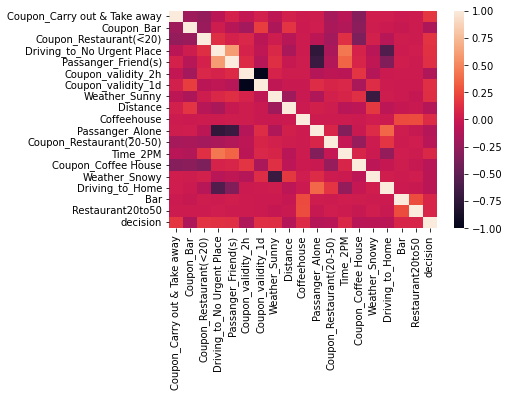

In [11]:
fig, ax = plt.subplots()
sns.heatmap(x_train_imputed
            .assign(decision=y_train)
            .loc[:, corrs.index[corrs > 0.075].append(pd.Index(['decision']))]
            .corr())

# Model 1: Bernoulli Naive Bayes with ICA

In [12]:
fast_ica = FastICA(24, max_iter=3000, tol=0.001)
x_train_ica = fast_ica.fit_transform(x_train_scaled)
X_train_ica, X_test_ica, Y_train_ica, Y_test_ica = train_test_split(
    x_train_ica, y_train, train_size=0.6
)

gnb = GaussianNB()
gnb.fit(X_train_ica, Y_train_ica)
gnb.score(X_test_ica, Y_test_ica)


/home/nimkar/miniconda3/envs/police/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


0.6512027491408935

In [13]:
gnb_pred, gnb_proba = gnb.predict(X_test_ica), gnb.predict_proba(X_test_ica)[:, 1]
print('roc auc score:', roc_auc_score(Y_test_ica, gnb_proba))
print('f1 score:', f1_score(Y_test_ica, gnb_pred))

roc auc score: 0.6927067013300584
f1 score: 0.7179996030958522


# Model 2: Logistic Regression with PCA

First we shall show the performance of a simple logistic regression model. The performance of more advanced linear classification models such as Ridge classifier were in the similar range as the simple logistic regression in this case

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x_train_scaled, y_train, train_size=0.6, random_state=1)


In [14]:
lr = LogisticRegression()
lr.fit(X_train.to_numpy(), Y_train.to_numpy())
lr.score(X_test, Y_test)

We see a significant improvement after applying PCA

In [15]:
pca = PCA(0.99)
x_train_pca = pca.fit_transform(x_train_scaled)
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(
    x_train_pca, y_train, train_size=0.6)

lr_pca = LogisticRegression(C=1)
lr_pca.fit(X_train_pca, Y_train_pca)
lr_pca.score(X_test_pca, Y_test_pca)


0.6779577810505646

In [16]:
lr_pca_pred, lr_pca_proba = lr_pca.predict(X_test_pca), lr_pca.predict_proba(X_test_pca)[:, 1]
print('roc auc score:', roc_auc_score(Y_test_pca, lr_pca_proba))
print('f1 score:', f1_score(Y_test_pca, lr_pca_pred))

roc auc score: 0.7327057493593443
f1 score: 0.7290375877736472


# Restoring the original `X_train`

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x_train_scaled, y_train, train_size=0.6, random_state=1)


# Deriving sample weights

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_train)
print((Y_train != Y_pred_knn).mean())

Sample_weight = np.where(Y_train != Y_pred_knn, 2, 1)
Sample_weight = Sample_weight / Sample_weight.sum()

/home/nimkar/miniconda3/envs/police/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.19574468085106383


# Model 3: Random forest classifier

In [19]:
n_estimator_score = []
for md in tqdm((256, 128, 64, 32, 16, 8, 4, 2)):
    for ne in tqdm((30, 54, 100, 180, 300, 540)):
        forest = RandomForestClassifier(
            n_estimators=ne, random_state=2, min_samples_split=3,
            max_depth=md
        )
        forest.fit(X_train, Y_train, sample_weight=Sample_weight)
        score = forest.score(X_test, Y_test)
        n_estimator_score.append((ne, md, score))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
nescore = pd.DataFrame(n_estimator_score, columns=['n_estimator', 'max_depth', 'score'])

In [21]:
print(nescore
      .groupby(['n_estimator', 'max_depth'])
      .agg({'score': 'mean'})
      .unstack()
      .droplevel(0, axis=1)
      .to_latex())


\begin{tabular}{lrrrrrrrr}
\toprule
max\_depth &       2   &       4   &       8   &       16  &       32  &       64  &       128 &       256 \\
n\_estimator &           &           &           &           &           &           &           &           \\
\midrule
30          &  0.608493 &  0.674767 &  0.704222 &  0.723368 &  0.725331 &  0.728522 &  0.728522 &  0.728522 \\
54          &  0.620275 &  0.679431 &  0.710604 &  0.733922 &  0.734659 &  0.734413 &  0.734413 &  0.734413 \\
100         &  0.623466 &  0.684094 &  0.716249 &  0.735641 &  0.737850 &  0.738832 &  0.738832 &  0.738832 \\
180         &  0.619784 &  0.683358 &  0.720668 &  0.735886 &  0.740304 &  0.742268 &  0.742268 &  0.742268 \\
300         &  0.616593 &  0.681640 &  0.719440 &  0.737850 &  0.741532 &  0.742023 &  0.742023 &  0.742023 \\
540         &  0.617329 &  0.680167 &  0.720668 &  0.739813 &  0.739323 &  0.739323 &  0.739323 &  0.739323 \\
\bottomrule
\end{tabular}



In [22]:
big_forest = RandomForestClassifier(
    n_estimators=3000, max_depth=128, min_samples_split=3)
big_forest.fit(X_train, Y_train)
big_forest.score(X_test, Y_test)

0.7417771232204222

In [23]:
big_forest_pred, big_forest_proba = (
    big_forest.predict(X_test), big_forest.predict_proba(X_test)[:, 1])
print('roc auc score:', roc_auc_score(Y_test, big_forest_proba))
print('f1 score:', f1_score(Y_test, big_forest_pred))

roc auc score: 0.8087146542777136
f1 score: 0.786178861788618


In [24]:
importances = big_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in big_forest.estimators_], axis=0)
importance_frame = (
    pd.DataFrame({'importances': importances, 'yerr': std}, 
                 index=x_train_scaled.columns)
    .sort_values('importances', ascending=False)
)

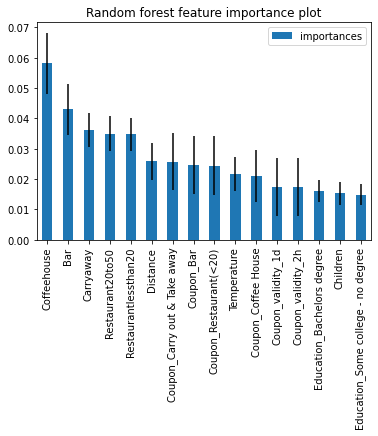

In [25]:
fig, ax = plt.subplots()
importance_frame.head(16).plot.bar(yerr='yerr', ax=ax)
ax.set_title('Random forest feature importance plot')
plt.show()

# Model 4: Gradient boosting classifier

Unfortunately, I deleted the cell where I searched for the optimal parameters using GridSearchCV. However, I had saved the output of the cell in an image which is attached in the project write-up.

In [26]:
gbcf = GradientBoostingClassifier(
    max_depth=None, min_samples_split=8, learning_rate=0.018, 
    n_estimators=400, random_state=2, subsample=0.3
)
gbcf.fit(X_train, Y_train, sample_weight=Sample_weight)
gbcf.score(X_test, Y_test)

0.7538046146293569

In [27]:
gbcf_pred, gbcf_proba = (
    gbcf.predict(X_test), gbcf.predict_proba(X_test)[:, 1])
print('roc auc score:', roc_auc_score(Y_test, gbcf_proba))
print('f1 score:', f1_score(Y_test, gbcf_pred))

roc auc score: 0.8239727955431101
f1 score: 0.7915194346289751


# Loading and preparing the test data

In [29]:
test = pd.read_csv('data/test.csv')

x_test = test[test.columns[test.columns != 'id']]
test_id = test['id']

x_test_dummies, filled = pd.get_dummies(x_test), {}
x_test_not_na = x_test_dummies.dropna()

for col in tqdm(x_test_dummies.columns):
    x_test_minus_col = x_test_not_na[
        x_test_not_na.columns[x_test_not_na.columns != col]]
    bnb = BernoulliNB()
    bnb.fit(x_test_minus_col, 
            x_test_not_na.loc[x_test_minus_col.index, col])
    pred = bnb.predict(x_test_dummies[x_test_minus_col.columns]
                       .fillna(method='ffill'))
    filled[col] = pred
    
x_test_imputed = x_test_dummies.fillna(pd.DataFrame(filled))
x_test_scaled = pd.DataFrame(scaler.transform(x_test_imputed),
                             index=x_test_imputed.index,
                             columns=x_test_imputed.columns)

x_test_scaled = x_test_scaled.loc[:, x_train_scaled.columns]

  0%|          | 0/86 [00:00<?, ?it/s]

# Training the final classifier on the complete training data

We are using the parameters obtained earlier directly to train the new classifier

In [30]:
knn = KNeighborsClassifier()
knn.fit(x_train_scaled, y_train)
y_pred_knn = knn.predict(x_train_scaled)
print((y_train != y_pred_knn).mean())

sample_weight = np.where(y_train != y_pred_knn, 2, 1)
sample_weight = sample_weight / sample_weight.sum()

/home/nimkar/miniconda3/envs/police/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.1923605655930872


In [31]:
start = time.time()
gbcf_final = GradientBoostingClassifier(
    max_depth=None, min_samples_split=3, learning_rate=0.018, 
    n_estimators=250, random_state=2, subsample=0.3
)
gbcf_final.fit(x_train_scaled, y_train, sample_weight=sample_weight)
elapsed = time.time() - start
print(f'trained in {elapsed} seconds')

trained in 21.044183492660522 seconds


In [32]:
start = time.time()
final_big_forest = RandomForestClassifier(
    n_estimators=3000, max_depth=128, min_samples_split=3)
final_big_forest.fit(x_train_scaled, y_train, sample_weight=sample_weight)
elapsed = time.time() - start
print(f'trained in {elapsed} seconds')

trained in 31.831401348114014 seconds


# Obtaining the prediction on test data

In [36]:
preds = gbcf_final.predict(x_test_scaled)
pd.DataFrame({'id': test_id, 'Decision': preds}).set_index('id').to_csv('output_gcbf.csv')

In [37]:
preds = final_big_forest.predict(x_test_scaled)
pd.DataFrame({'id': test_id, 'Decision': preds}).set_index('id').to_csv('output_forest.csv')